In [16]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode

This is to create the coco JSON files, only run this for setup

In [20]:
# run this only if setup is not complete 
import os
os.chdir('../lib')
import importlib, setup_coco_json, process_coco_json

importlib.reload(setup_coco_json)
importlib.reload(process_coco_json)

from setup_coco_json import setup_rgb, setup_grayscale, setup_rgbd
from process_coco_json import get_coco_rgb, get_coco_grayscale, get_coco_rgbd

os.chdir('../data')
setup_rgb('./useable_data', coco_json_dir='./coco_json', per_train=75, per_val=15, per_test=15)
get_coco_rgb("./coco_json/rgb/")

Saving Contour Plots: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

Number of Images: 1

Number of Train Images: 1
Number of Val Images: 0
Number of Test Images: 0
Images have been saved to ./coco_json/grayscale/train/images
Images have been saved to ./coco_json/grayscale/train/masks/Tumor
Images have been saved to ./coco_json/grayscale/val/images
Images have been saved to ./coco_json/grayscale/val/masks/Tumor
Images have been saved to ./coco_json/grayscale/test/images
Images have been saved to ./coco_json/grayscale/test/masks/Tumor
Created 1 annotations for images in folder: ./coco_json/grayscale/train/masks
Created 0 annotations for images in folder: ./coco_json/grayscale/val/masks
Created 0 annotations for images in folder: ./coco_json/grayscale/test/masks
Done creating COCO JSON annotations for all files


In [21]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "../data/coco_json/rgb/train/images/train.json", "../data/coco_json/rgb/train/images/")
register_coco_instances("my_dataset_val", {}, "../data/coco_json/rgb/val/images/val.json", "../data/coco_json/rgb/val/images/")
register_coco_instances("my_dataset_test", {}, "../data/coco_json/rgb/test/images/test.json", "../data/coco_json/rgb/test/images/")

In [22]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[09/27 03:21:49 d2.data.datasets.coco]: Loaded 192 images in COCO format from ../data/coco_json/rgb/train/images/train.json
[09/27 03:21:49 d2.data.datasets.coco]: Loaded 41 images in COCO format from ../data/coco_json/rgb/val/images/val.json
[09/27 03:21:49 d2.data.datasets.coco]: Loaded 42 images in COCO format from ../data/coco_json/rgb/test/images/test.json


Image file: ../data/coco_json/rgb/train/images/train_mask_20.png
Mask file: ../data/coco_json/rgb/train/masks/Tumor/train_mask_20.png


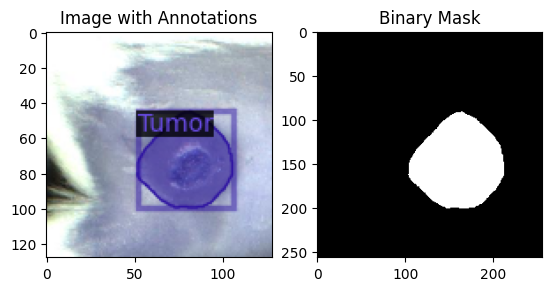

In [5]:
mask_folder = "../data/coco_json/rgb/train/masks/Tumor"  # Update with your binary mask folder path

for d in random.sample(train_dataset_dicts, 1):
    # Load the image
    img = cv2.imread(d["file_name"])

    print(f"Image file: {d['file_name']}")
    
    # Check if the image was successfully loaded
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue

    # Visualize the image with annotations
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    # Display the annotated image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.title("Image with Annotations")

    # Load the corresponding binary mask
    image_base_name = os.path.basename(d["file_name"]).split(".")[0]  # Get base name of the image
    mask_path = os.path.join(mask_folder, f"{image_base_name}.png")  # Assuming masks have .png extension

    print(f"Mask file: {mask_path}")
    
    # Load the binary mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the mask was successfully loaded
    if mask_img is None:
        print(f"Failed to load mask: {mask_path}")
        continue

    # Display the binary mask
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.imshow(mask_img, cmap="gray")
    plt.title("Binary Mask")

    plt.show()  # Display the images side by side

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = '../models/detectron2'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/27 02:30:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/27 02:30:45 d2.engine.train_loop]: Starting training from iteration 0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/27 02:30:54 d2.utils.events]:  eta: 0:11:22  iter: 19  total_loss: 1.65  loss_cls: 0.7305  loss_box_reg: 0.1538  loss_mask: 0.6903  loss_rpn_cls: 0.01417  loss_rpn_loc: 0.01562    time: 0.3435  last_time: 0.3471  data_time: 0.0083  last_data_time: 0.0037   lr: 4.9953e-06  max_mem: 1768M
[09/27 02:31:01 d2.utils.events]:  eta: 0:10:58  iter: 39  total_loss: 1.548  loss_cls: 0.6106  loss_box_reg: 0.1726  loss_mask: 0.6858  loss_rpn_cls: 0.05658  loss_rpn_loc: 0.02016    time: 0.3400  last_time: 0.3347  data_time: 0.0037  last_data_time: 0.0037   lr: 9.9902e-06  max_mem: 1768M
[09/27 02:31:08 d2.utils.events]:  eta: 0:10:56  iter: 59  total_loss: 1.381  loss_cls: 0.4676  loss_box_reg: 0.1552  loss_mask: 0.6785  loss_rpn_cls: 0.0185  loss_rpn_loc: 0.01333    time: 0.3418  last_time: 0.3378  data_time: 0.0039  last_data_time: 0.0037   lr: 1.4985e-05  max_mem: 1768M
[09/27 02:31:15 d2.utils.events]:  eta: 0:10:50  iter: 79  total_loss: 1.206  loss_cls: 0.3326  loss_box_reg: 0.1555  loss_

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/27 03:08:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/detectron2/model_final.pth ...


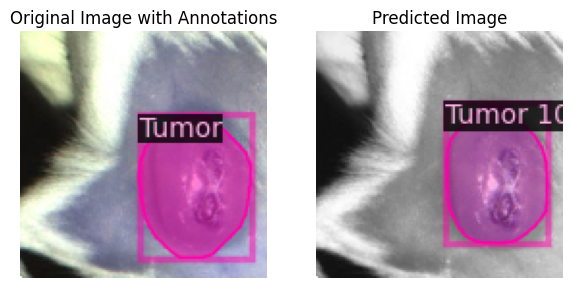

In [26]:


# Function to display the original image with annotations and the predicted image
def display_original_and_prediction_with_annotations(val_dataset_dicts, predictor, val_metadata):
    for d in random.sample(val_dataset_dicts, 1):  # Select number of images for display
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        # Create a visualizer object for the original image with annotations
        v_gt = Visualizer(im[:, :, ::-1],
                          metadata=val_metadata,
                          scale=0.5
        )
        out_gt = v_gt.draw_dataset_dict(d)
        
        # Create a visualizer object for the predicted image
        v_pred = Visualizer(im[:, :, ::-1],
                            metadata=val_metadata,
                            scale=0.5,
                            instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
        )
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Set up subplots
        fig, ax = plt.subplots(1, 2, figsize=(7,7))
        
        # Display the original image with annotations
        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Original Image with Annotations')
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Predicted Image')

        for a in ax:
            a.axis("off")
        
        plt.show()

# Example usage
display_original_and_prediction_with_annotations(val_dataset_dicts, predictor, test_metadata)


In [15]:
def save_all_images(val_dataset_dicts, predictor, val_metadata, output_dir):
    
    #create image path if it doesnt exist 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, d in enumerate(val_dataset_dicts):

        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        v_gt = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5)
        out_gt = v_gt.draw_dataset_dict(d)
        
        v_pred = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        fig, ax = plt.subplots(1, 2, figsize=(30, 30))

        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Image with Original Annotations', fontsize=24)
        ax[0].axis('off')
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Images with Annotations produced by the model', fontsize=24)
        ax[1].axis('off')
        
        fig.savefig(os.path.join(output_dir, f"image_{i}.png"), bbox_inches="tight")
        plt.close(fig) 

In [16]:
save_all_images(test_dataset_dicts, predictor, test_metadata, './detectron2/images_rgb')